In [25]:
import IMProToo
import xarray as xr
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sys
import  os       
import tikzplotlib

from matplotlib.patches import Rectangle 

directorio_actual = os.getcwd()
print("Estoy en:", directorio_actual)   # ubicacion de donde estamos

Estoy en: C:\Users\Kanty\Documents\GitHub\RadarVisualisation\PlotRadar


In [32]:
#cargamos la base
ds = xr.open_dataset('C:/Users/Kanty/Documents/mrr2c/2024_0806_mrr2c_1.nc')
#ds.head()   # para ver la cantidad de variables y tipos

<xarray.Dataset>
Dimensions:                        (time: 5, level: 5, band: 5)
Coordinates:
  * band                           (band) float64 0.0 1.0 2.0 3.0 4.0
  * level                          (level) float64 0.0 1.0 2.0 3.0 4.0
  * time                           (time) datetime64[ns] 2024-08-06T00:00:21 ...
Data variables: (12/22)
    attenuated_radar_reflectivity  (time, level) float64 ...
    averaging_time                 (time) float64 ...
    calibration_constant           (time) float64 ...
    device_serial_number           (time) object ...
    drop_size                      (time, level, band) float64 ...
    fall_velocity                  (time, level) float64 ...
    ...                             ...
    service_version                (time) object ...
    spectral_drop_density          (time, level, band) float64 ...
    spectral_reflectivity          (time, level, band) float64 ...
    time_zone                      (time) object ...
    transfer_function              (time, level) float64 ...
    valid_spectra_percentage       (time) float64 ...
Attributes:
    software:  mrr2c (https://github.com/peterkuma/mrr2c)
    version:   3.0.0
    created:   2024-08-06T15:50:11Z

In [27]:
# Uso de colores hexadecimal personificados 
paleta0 = ['#ccd8ff','#3366ff','#9fdf9f','#00b300','#ffff00','#ffcc30','#e62e00','#ff6600','#fff0e5','#c03fc0','#602060']
paleta1 = ['#ffe5d9','#ffb3b3','#ffcc99','#ffffcc','#ccffcc','#b3e0ff','#b3b3ff','#e5ccff','#ffcce5','#ffd9b3','#ffe5b3']
paleta2 = ['#390099','#6C0079','#9E0059','#CF0057','#FF0054','#FF2A2A','#FF5400','#FF8900','#FFBD00','#FFC317','#FFC82C']
paleta3 = ['#000814','#001329','#001D3D','#002952','#003566','#40594D','#807C33','#A08E27','#C0A01A','#FFC300','#FFD60A']

def add_no_data(ax,times,xlim):
    cs = ax.contourf([times[0],times[-1]], [0,600], np.ones((2,2)), 
                    colors='none', edgecolor='red', hatches=['////'], zorder=0)
    for i, collection in enumerate(cs.collections):
        collection.set_edgecolor('gray3')
    middleIndex = int((len(times) - 1)/2)
    ax.text(xlim[0], 300, 'Sin Datos', 
                color='gray8',
                ha='left',va='center',
                zorder=1,
                )

def plot_mrr2(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex = paleta3):                   # aca cargar paleta de colores personalizada a usar
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
            cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
      xlabel = r'Hora Local $\rightarrow$'
    else:
      xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
      ylim = [0, 3600]
    else:
      ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()
    
    if total_seconds <= 14400:
      xlocator=('hour',range(0,24,1))
      xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
      xlocator=('hour',range(0,24,3))
      xminorlocator=('hour',range(0,24,1))
    else:      
      xlocator=('hour',range(0,24,6))
      xminorlocator=('hour',range(0,24,2))


    if Vf is None:

      if ax is None:
        fig, ax = pplt.subplots(refwidth=5, refaspect=3)

      mZe = ax.pcolormesh(times, heights, Ze,  
                        norm=norm, cmap=dbzmap, 
                        shading='auto', # permite que tickmark esté en centro de celda
                      #   extend='both'
                        )		

      ax.format(	ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc=ytickloc,
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7,)
        
      if xlim != '':
          ax.format(xlim=xlim)    
      
    else:
      
      fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

      mZe = ax[0].pcolormesh(times, heights, Ze,  
                        norm=norm, cmap=dbzmap, 
                        shading='auto', # permite que tickmark esté en centro de celda
                       #extend='both'
                        )		
      add_no_data(ax[0], times, xlim)   
      
      mVf = ax[1].pcolormesh(times, heights, Vf, 
                            vmin=-3,vmax=10,        # Aca cambiar a la paleta de colores predeterminadas a usar 
                             #cmap='Spectral',      # Colores paleta espectro visual
                             #cmap='RdYlGn',        # Colores paleta rojo-amarillo-verde
                             #cmap='RdYlBu',        # Colores paleta rojo-amarillo-azul
                             #cmap='RdGy',          # Colores paleta rojo-gris
                             #cmap='RdBu',          # Colores paleta rojo-azul
                             cmap='PuOr',           # Colores paleta purpura-naranja
                             #cmap='PRGn',          # Colores paleta purpura(rojiza)-verde(amarillento)
                             #cmap='PiYG',          # Colores paleta rosa-amarillo-verde
                             #cmap='BrBG',          # Colores paleta marron-azul(verdoso)
                            shading='auto',
                           #extend='both'
                            )	
      add_no_data(ax[1], times, xlim)

      ax[0].format(	ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4,)
      
      ax[1].format(	ultitle='Velocidad de caída',
                      xrotation=False,
                      #   xformatter='%b-%d\n%H:%M',
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
          )
      ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, 
                    extend='both')
  
      if xlim != '':
          ax[0].format(xlim=xlim)
          ax[1].format(xlim=xlim)
    
    fig.show()	

C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_9692\651694349.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


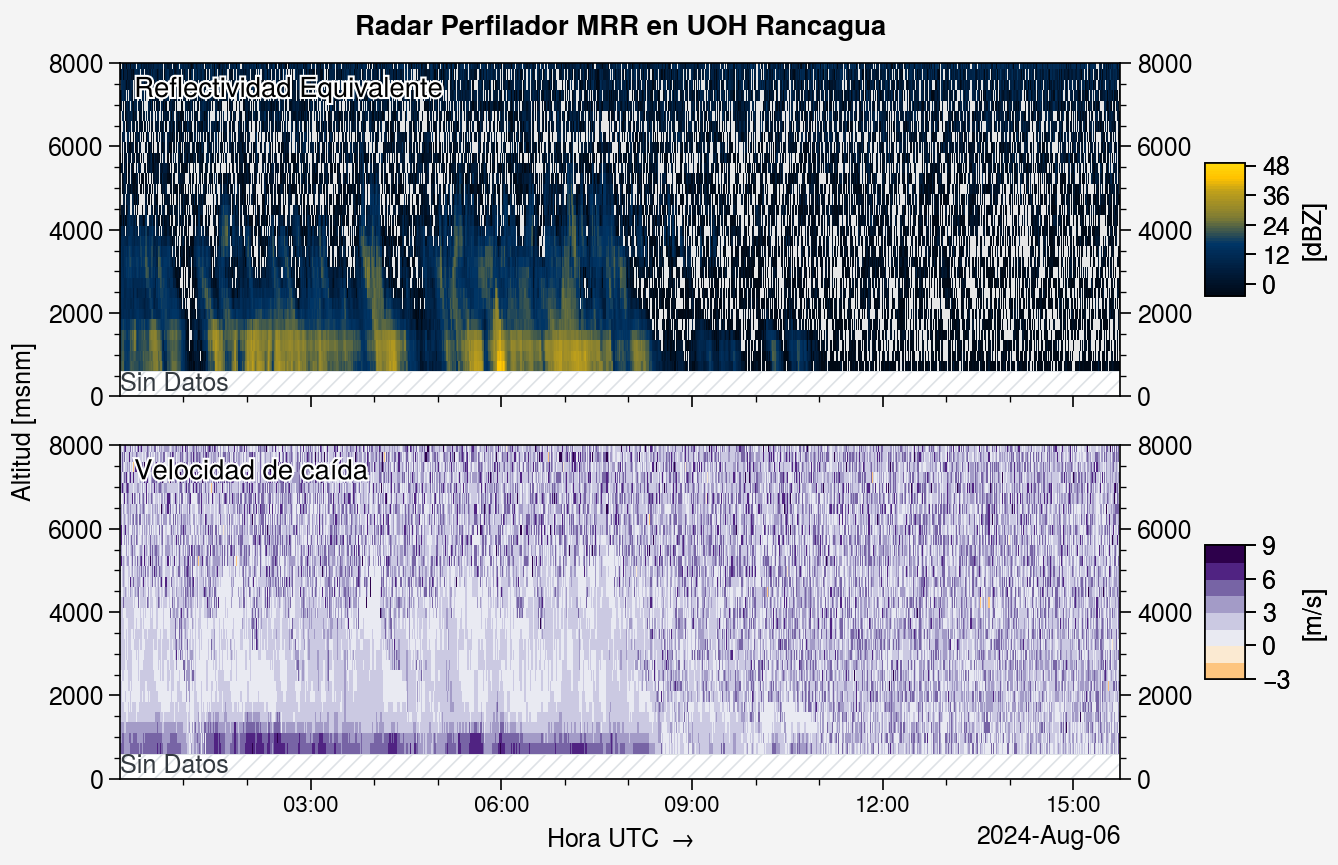

In [30]:
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0,:]+500
Ze = ds['attenuated_radar_reflectivity'].T
Vf = ds['fall_velocity'].T
# llamar a la funcion para plotear
plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze, Vf, hora_local=False)
plt.savefig("2024_0806_mrr2c_1.png")